## Backtesting Trading Strategies

Let's take the Golden and Death cross example from the technical analysis file and simulate a simple trading strategy where we buy on the Golden Cross and sell on the Death Cross. For simplicity, we will only simulate long positions (no short selling).

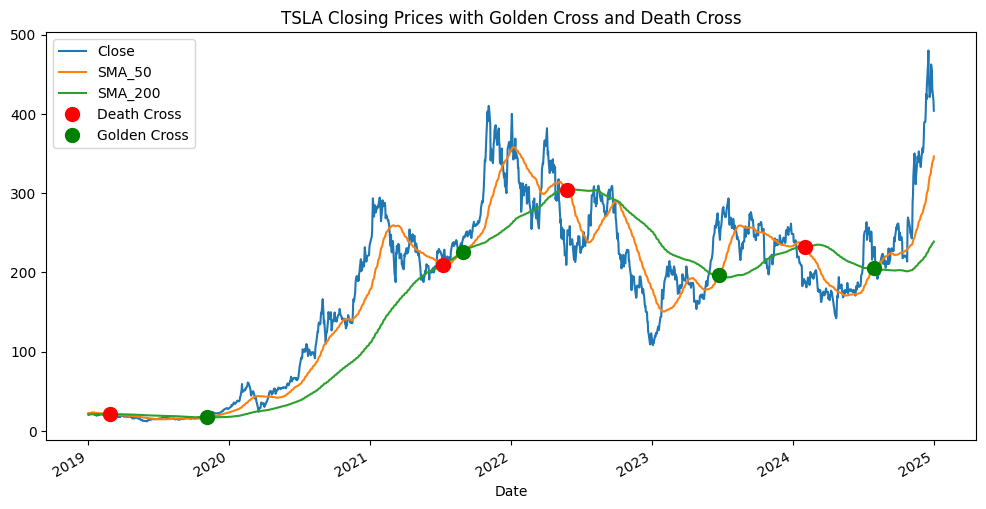

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf

tesla_df = yf.Ticker("TSLA").history(period="max")

tesla_df['SMA_50'] = tesla_df['Close'].rolling(window=50).mean()
tesla_df['SMA_200'] = tesla_df['Close'].rolling(window=200).mean()

tesla_df['Signal'] = 0
tesla_df.loc[tesla_df['SMA_50'] > tesla_df['SMA_200'], 'Signal'] = 1
tesla_df.loc[tesla_df['SMA_50'] < tesla_df['SMA_200'], 'Signal'] = -1

tesla_df['Crossover'] = tesla_df['Signal'].diff()

tesla_df_small = tesla_df.loc['2019':'2024']

fig, ax = plt.subplots(figsize=(12, 6))
tesla_df_small[['Close', 'SMA_50', 'SMA_200']].plot(ax=ax, title="TSLA Closing Prices with Golden Cross and Death Cross")

crosses = tesla_df_small[tesla_df_small['Crossover'] != 0]
for idx, row in crosses.iterrows():
    if row['Crossover'] == 2:
        plt.plot(idx, row['SMA_50'], 'go', markersize=10, label='Golden Cross' if 'Golden Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    elif row['Crossover'] == -2:
        plt.plot(idx, row['SMA_50'], 'ro', markersize=10, label='Death Cross' if 'Death Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    plt.legend()

plt.show()

In [2]:
initial_capital = 10000
end_capital = initial_capital
buy_price = 0

for idx, row in crosses.iterrows():
    # Simulating buying on Golden Cross
    if row['Crossover'] == 2:
        buy_price = row['Close']
        print(f'Bought at: ${buy_price:.2f}.')

    # Simulating selling on Death Cross
    elif row['Crossover'] == -2 and buy_price != 0:
        sell_price = row['Close']
        gain_pct = (sell_price-buy_price) / buy_price
        print(f'Sold at: ${sell_price:.2f}. Gained {gain_pct*100:.2f}%.')
        end_capital = (1+gain_pct) * end_capital

# Calculating total gain percentage
total_pct_gain = (end_capital-initial_capital) / initial_capital

print(f'Initial: ${initial_capital}. Ended with: ${end_capital:.2f}. Gained: {total_pct_gain*100:.2f}%.') 

Bought at: $21.15.
Sold at: $218.98. Gained 935.48%.
Bought at: $243.64.
Sold at: $235.91. Gained -3.17%.
Bought at: $256.60.
Sold at: $188.86. Gained -26.40%.
Bought at: $232.10.
Initial: $10000. Ended with: $73795.31. Gained: 637.95%.


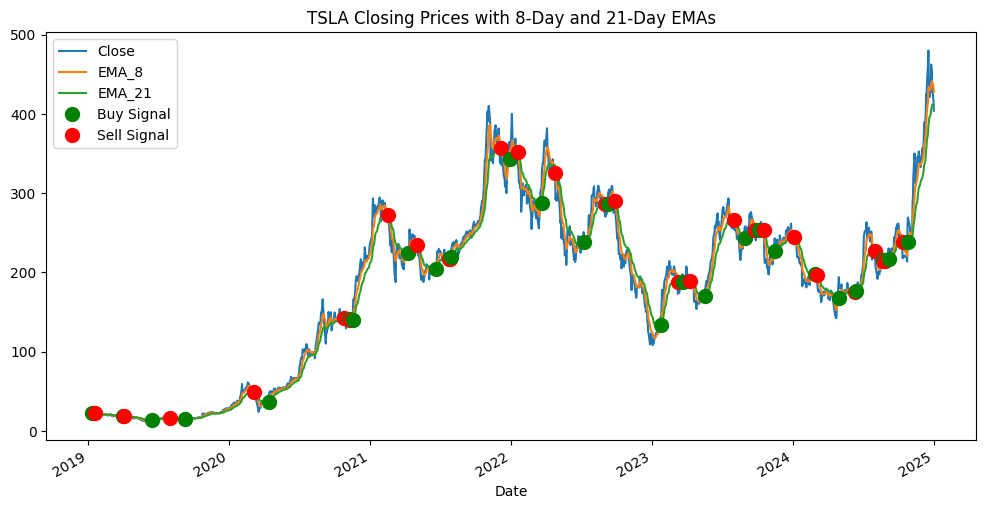

In [3]:
import mplfinance as mpf 

tesla_df['EMA_8'] = tesla_df['Close'].ewm(span=8).mean()
tesla_df['EMA_21'] = tesla_df['Close'].ewm(span=21).mean()

tesla_df['EMA_Signal'] = 0
tesla_df.loc[tesla_df['EMA_8'] > tesla_df['EMA_21'], 'EMA_Signal'] = 1
tesla_df.loc[tesla_df['EMA_8'] < tesla_df['EMA_21'], 'EMA_Signal'] = -1

tesla_df['EMA_Crossover'] = tesla_df['EMA_Signal'].diff()
tesla_df_small = tesla_df.loc['2019':'2024']

fig, ax = plt.subplots(figsize=(12, 6))
tesla_df_small[['Close', 'EMA_8', 'EMA_21']].plot(ax=ax, title="TSLA Closing Prices with 8-Day and 21-Day EMAs")

ema_crosses = tesla_df_small[tesla_df_small['EMA_Crossover'] != 0]
for idx, row in ema_crosses.iterrows():
    if row['EMA_Crossover'] == 2:
        plt.plot(idx, row['EMA_8'], 'go', markersize=10, label='Buy Signal' if 'Buy Signal' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    elif row['EMA_Crossover'] == -2:
        plt.plot(idx, row['EMA_8'], 'ro', markersize=10, label='Sell Signal' if 'Sell Signal' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    plt.legend()

plt.show()

In [25]:
initial_capital = 10000
end_capital = initial_capital
buy_price = 0
buys = 0
sells = 0
gains = []
losses = []
loss_hold_time = []
gain_hold_time = []
current_date = tesla_df_small.index[0]

for idx, row in ema_crosses.iterrows():
    
    if row['EMA_Crossover'] == 2:
        buy_price = row['Close']
        current_date = idx
        buys += 1
        print(f'Bought at: ${buy_price:.2f}.')

    # Simulating selling on Death Cross
    elif row['EMA_Crossover'] == -2 and buy_price != 0:
        sell_price = row['Close']
        days_passed = (idx-current_date).days
        sells += 1
        gain_pct = (sell_price-buy_price) / buy_price
        print(f'Sold after {days_passed} days at: ${sell_price:.2f}.', end=" ")
        if gain_pct > 0:
            gains.append(gain_pct)
            gain_hold_time.append(days_passed)
            print(f'Gained {gain_pct*100:.2f}%.')
        else:
            losses.append(gain_pct)
            loss_hold_time.append(days_passed)
            print(f'Lost {gain_pct*100:.2f}%.')
        end_capital = (1+gain_pct) * end_capital

# Calculating total gain percentage
total_pct_gain = (end_capital-initial_capital) / initial_capital

holding_time = gain_hold_time + loss_hold_time

print(f'Initial: ${initial_capital}. Ended with: ${end_capital:.2f}. Gained: {total_pct_gain*100:.2f}%.') 
print(f'Total Buys: {buys}. Total Sells: {sells}. Max Drawdown: {min(losses)*100:.2f}%.')
print(f'Average gain: {sum(gains)/len(gains)*100:.2f}%. Average loss: {sum(losses)/len(losses)*100:.2f}%.')
print(f'Average holding time: {int(sum(holding_time)/len(holding_time))} days.')
print(f'Average gain holding time: {int(sum(gain_hold_time)/len(gain_hold_time))} days. Longest gain holding time: {max(gain_hold_time)} days.')
print(f'Average loss holding time: {int(sum(loss_hold_time)/len(loss_hold_time))} days. Longest loss holding time: {max(loss_hold_time)} days.')


Bought at: $23.15.
Sold after 7 days at: $20.15. Lost -12.96%.
Bought at: $19.45.
Sold after 1 days at: $17.85. Lost -8.23%.
Bought at: $15.00.
Sold after 46 days at: $15.62. Gained 4.14%.
Bought at: $15.45.
Sold after 179 days at: $46.90. Gained 203.50%.
Bought at: $43.40.
Sold after 196 days at: $140.09. Gained 222.82%.
Bought at: $143.32.
Sold after 4 days at: $136.79. Lost -4.56%.
Bought at: $147.20.
Sold after 92 days at: $266.05. Gained 80.74%.
Bought at: $225.67.
Sold after 24 days at: $228.30. Gained 1.16%.
Bought at: $206.94.
Sold after 32 days at: $214.46. Gained 3.63%.
Bought at: $219.21.
Sold after 1 days at: $214.93. Lost -1.95%.
Bought at: $225.78.
Sold after 130 days at: $336.34. Gained 48.96%.
Bought at: $362.82.
Sold after 21 days at: $343.50. Lost -5.32%.
Bought at: $307.05.
Sold after 36 days at: $292.14. Lost -4.86%.
Bought at: $250.76.
Sold after 54 days at: $275.61. Gained 9.91%.
Bought at: $299.68.
Sold after 17 days at: $276.01. Lost -7.90%.
Bought at: $143.89.


Let's compare this to just holding the stock throughout this whole period.

In [24]:
buy_price = tesla_df['Close'].iloc[0]
sell_price = tesla_df['Close'].iloc[-1]
max_drawdown = 0
periods_red = []
days_red = 0
longest_period = 0

for idx, row in tesla_df.iterrows():
    gain_pct = (row['Close']-buy_price) / buy_price
    if gain_pct < max_drawdown:
        max_drawdown = gain_pct
    if gain_pct < 0:
        days_red += 1
        if days_red > longest_period:
            longest_period = days_red
    else:
        if days_red > 0:
            periods_red.append(days_red)
            days_red = 0
        
final_gain_pct = (sell_price-buy_price) / buy_price
end_capital = (1+final_gain_pct) * initial_capital
print(f'Initial: ${initial_capital}. Ended with: ${end_capital:.2f}. Gained: {final_gain_pct*100:.2f}%.')
print(f'Max Drawdown: {max_drawdown*100:.2f}%.')
print(f'Total holding time: {len(tesla_df)} days.')
print(f'Average drawdown period: {int(sum(periods_red)/len(periods_red))} days. Longest drawdown period: {longest_period} days.')

Initial: $10000. Ended with: $2677898.17. Gained: 26678.98%.
Max Drawdown: -33.86%.
Total holding time: 3663 days.
Average drawdown period: 10 days. Longest drawdown period: 89 days.
